In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp as smm
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
#current_palette = sns.color_palette("hls", 8)
#sns.set_palette(current_palette)

In [3]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

In [4]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

# Separate into seasons
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')
seas_df = seasons.to_dataframe()
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

djf_df.reset_index(inplace=True)
jja_df.reset_index(inplace=True)
mam_df.reset_index(inplace=True)
son_df.reset_index(inplace=True)

del djf_df['index']
del jja_df['index']
del mam_df['index']
del son_df['index']

djf_df.columns = ['year', 'season', 'seaice_conc']
jja_df.columns = ['year', 'season', 'seaice_conc']
mam_df.columns = ['year', 'season', 'seaice_conc']
son_df.columns = ['year', 'season', 'seaice_conc']

del djf_df['season']
del jja_df['season']
del mam_df['season']
del son_df['season']

In [5]:
seasons = ['JJA', 'SON', 'DJF', 'MAM']
dfs = {'DJF': djf_df, 'JJA': jja_df, 'MAM': mam_df, 'SON': son_df}

In [6]:
cmap = {'JJA': 'crimson', 'SON': 'darkorange', 'DJF': 'steelblue', 'MAM': 'seagreen'}

## Arctic splines

Since the arctic sea data set is such a long time series, we'll compute linear splines to get a piecewise trend of the data.

#### Definitions:

* A **linear spline** is a continuous function formed by connecting linear
segments.  The points where the segments connect are called the
**knots** of the spline.

* A **spline of degree** $D$ is a function formed by connecting polynomial segments
of degree $D$ so that:
    * the function is continuous,
    * the function has $D-1$ continuous derivatives,
    * the $D^{\text{th}}$ derivative is constant between knots

* The **truncated polynomial** of degree $D$ associated with knot $\xi_{k}$ is the function which is equal to $0$ to the left of $\xi_{k}$ and equal to $(x-\xi_{k})^D$ to the right of $\xi_{k}$.

$$(x-\xi_{k})_{+}^D = 
\begin{cases}
(x-\xi_{k})^D, & \text{if $x \geq \xi_{k}$} \\
0, & \text{if $x \lt \xi_{k}$}
\end{cases}
$$


#### Equation of spline of degree $D$ and $K$ knots:

$$y = \beta_{0} + \sum_{d=1}^{D}\beta_{d}x_{d} + \sum_{k=1}^{K}\alpha_{k}(x-\xi_{k})_{+}^D$$

#### Design Matrix:
$$
\mathbf{X} = 
\begin{bmatrix}
1 & x_1 & x_{1}^{2} & \dots & x_{1}^{D} & (x_{1}-\xi_{1})_{+}^D & \dots & (x_{1}-\xi_{K})_{+}^D \\
1 & x_2 & x_{2}^{2} & \dots & x_{2}^{D} & (x_{2}-\xi_{1})_{+}^D & \dots & (x_{2}-\xi_{K})_{+}^D \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_{n}^{2} &\dots & x_{n}^{D} & (x_{n}-\xi_{1})_{+}^D & \dots & (x_{n}-\xi_{K})_{+}^D
\end{bmatrix}
$$

In [7]:
def linear_splines(data, knots, degree=1):
    minyr = data.year.min()
    nyrs = data.year.shape[0]

    # Use indices of years for knots
    minyr = data.year.min()
    knots2 = [k-minyr for k in knots]
    
    # Column vector for beta1 are (t1, t2,...,tn)
    X1 = np.arange(nyrs)
    X1 = X1[:, np.newaxis]
    
    # Generate design matrix
    X2 = np.zeros((nyrs, len(knots2)))
    for col, k in enumerate(knots2):
        X2[k:, col] = np.abs(X2[k:, col] - X1[:nyrs-k, 0])
    X = np.hstack((X1, X2))
    return smf.glm('seaice_conc ~ X', data=data).fit()

In [8]:
# Define the knots
jjaknots = [1917, 1944, 1996]
#jjaknots2 = [1893, 1899, 1917, 1943, 1996]
sonknots = [1917, 1943, 1996]
djfknots = [1974, 1996]
mamknots = [1933, 1979]

splines = {'JJA': linear_splines(jja_df, jjaknots),
           'SON': linear_splines(son_df, sonknots),
           'DJF': linear_splines(djf_df, djfknots),
           'MAM': linear_splines(mam_df, mamknots)}

In [9]:
def plot_splines(yrs, conc, preds, label, season=None, ax=None, col='g'):
    if ax is None:
        ax = plt.gca()
    spl = ax.plot(yrs, conc, alpha=0.3, color='k')
    ax.plot(yrs, preds, label=label, color=col)
    ax.legend()
    ax.set_xlim(1845, 2016)
    #ax.set_ylim(17.5, 26)
    ax.set_xlabel('years')
    ax.set_ylabel('seaice_conc')
    ax.set_title('Linear Splines for {}'.format(season))
    return spl

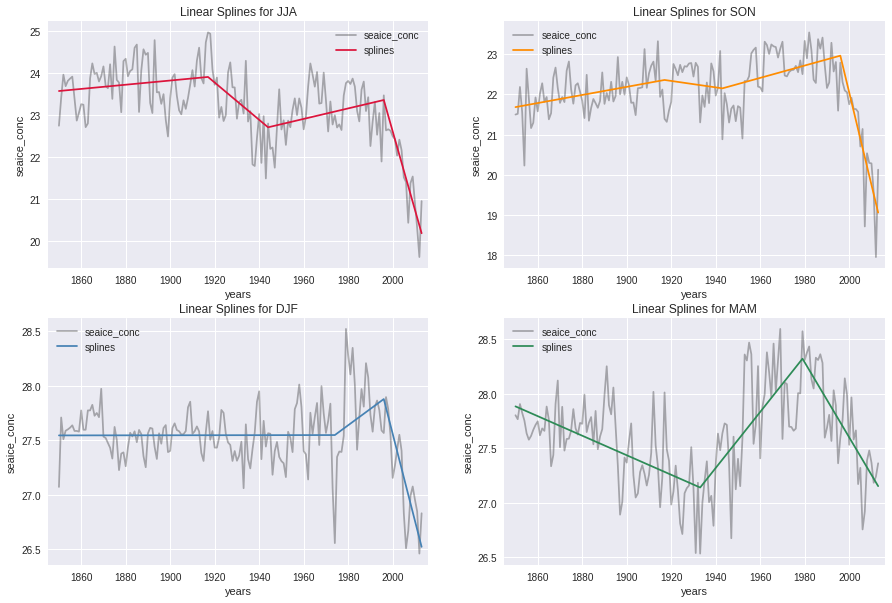

In [10]:
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

In [11]:
nyrs = yr_avg.shape[0]
#nparams = len(knots) + 2

# Estimates
mu_hat = {season: spl.mu for season, spl in splines.items()}
R = {season: spl.resid_response.values for season, spl in splines.items()}
cov = {season: spl.cov_params() for season, spl in splines.items()}
#sigma_hat2 = {season: np.sum(r**2) / (nyrs-nparams) for season, r in R.items()}
pvals = {season: spl.pvalues.values for season, spl in splines.items()}

In [12]:
bonferonnis = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals.items()}

In [13]:
for season, test in bonferonnis.items():
    print('{}: {}'.format(season, test[0]))

DJF: [ True False  True  True]
MAM: [ True  True  True  True]
JJA: [ True False  True  True  True]
SON: [ True  True False False  True]


In [14]:
# Splines with new knots... Pt.2
jjaknots2 = [1944, 1996]
sonknots2 = [1917, 1996]
djfknots2 = [1996]
mamknots2 = [1933, 1979]

splines2 = {'JJA': linear_splines(jja_df, jjaknots2),
           'SON': linear_splines(son_df, sonknots2),
           'DJF': linear_splines(djf_df, djfknots2),
           'MAM': linear_splines(mam_df, mamknots2)}

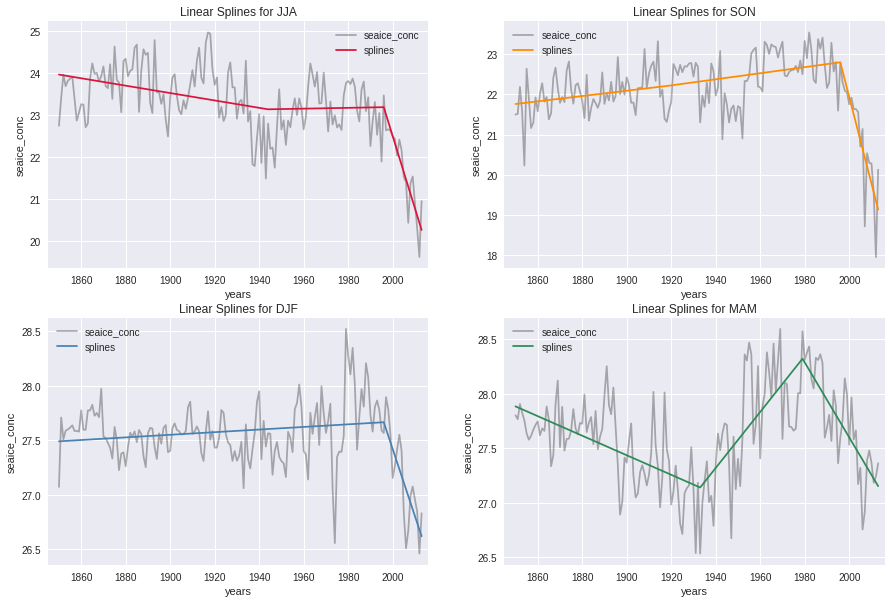

In [15]:
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines2[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

In [16]:
# Estimates Pt.2
mu_hat2 = {season: spl.mu for season, spl in splines2.items()}
R2 = {season: spl.resid_response.values for season, spl in splines2.items()}
cov2 = {season: spl.cov_params() for season, spl in splines2.items()}
pvals2 = {season: spl.pvalues.values for season, spl in splines2.items()}

bonferonnis2 = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals2.items()}

for season, test in bonferonnis2.items():
    print('{}: {}'.format(season, test[0]))

DJF: [ True  True  True]
MAM: [ True  True  True  True]
JJA: [ True  True False  True]
SON: [ True  True False  True]


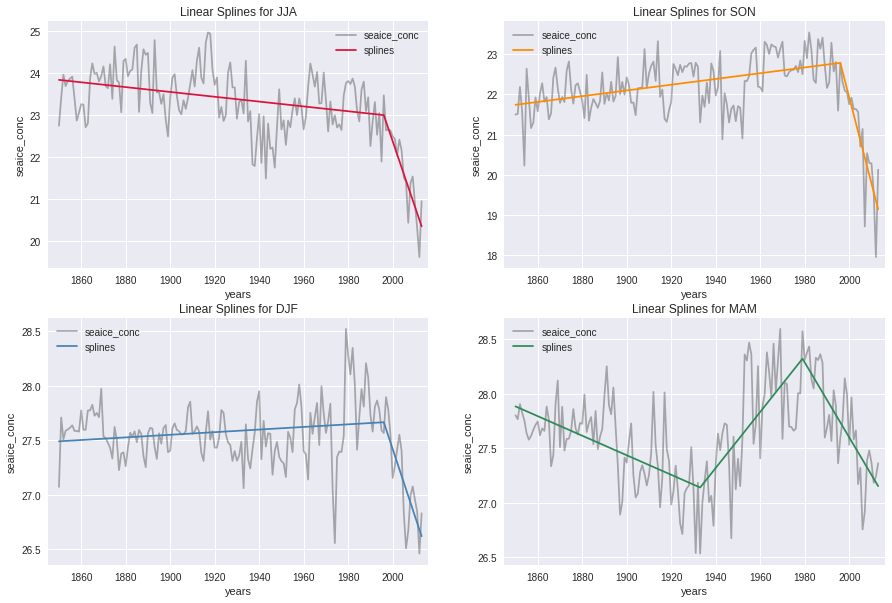

In [17]:
# Estimates Pt.3
jjaknots3 = [1996]
sonknots3 = [1996]
djfknots3 = [1996]
mamknots3 = [1933, 1979]

splines3 = {'JJA': linear_splines(jja_df, jjaknots3),
           'SON': linear_splines(son_df, sonknots3),
           'DJF': linear_splines(djf_df, djfknots3),
           'MAM': linear_splines(mam_df, mamknots3)}

f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines3[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

In [18]:
# Bonferonnis Pt.3
mu_hat3 = {season: spl.mu for season, spl in splines3.items()}
R3 = {season: spl.resid_response.values for season, spl in splines3.items()}
cov3 = {season: spl.cov_params() for season, spl in splines3.items()}
pvals3 = {season: spl.pvalues.values for season, spl in splines3.items()}

bonferonnis3 = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals3.items()}

for season, test in bonferonnis3.items():
    print('{}: {}'.format(season, test[0]))

DJF: [ True  True  True]
MAM: [ True  True  True  True]
JJA: [ True  True  True]
SON: [ True  True  True]


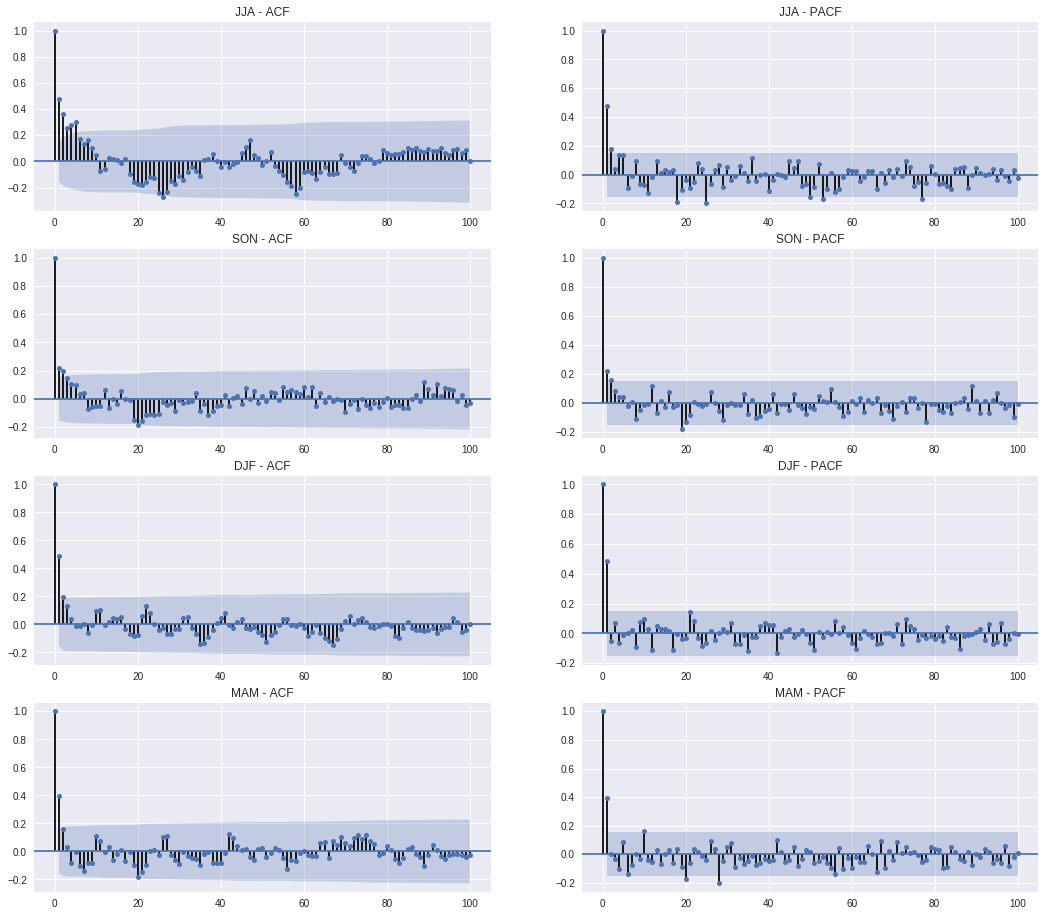

In [19]:
# Plot ACFs and PACFs
f, axs = plt.subplots(4, 2, figsize=(18,16))

jja_acf = plot_acf(R3['JJA'], lags=100, title ='JJA - ACF', ax=axs[0,0])
jja_pacf = plot_pacf(R3['JJA'], lags=100, title='JJA - PACF', ax=axs[0,1])

son_acf = plot_acf(R3['SON'], lags=100, title='SON - ACF', ax=axs[1,0])
son_pacf = plot_pacf(R3['SON'], lags=100, title='SON - PACF', ax=axs[1,1])

djf_acf = plot_acf(R3['DJF'], lags=100, title='DJF - ACF', ax=axs[2,0])
djf_pacf = plot_pacf(R3['DJF'], lags=100, title='DJF - PACF', ax=axs[2,1])

mam_acf = plot_acf(R3['MAM'], lags=100, title='MAM - ACF', ax=axs[3,0])
mam_pacf = plot_pacf(R3['MAM'], lags=100, title='MAM - PACF', ax=axs[3,1])

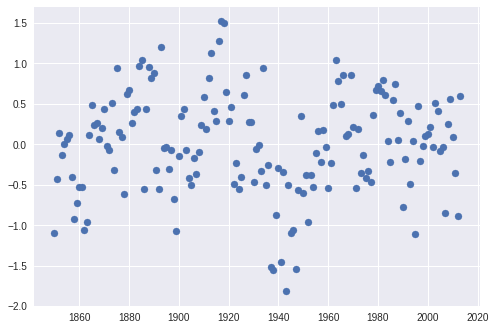

In [20]:
#f, ax = plt.subplots(1,1, figsize=(20,15))

plt.scatter(jja_df.year, R3['JJA'])

In [21]:
# Compute FFT of the residuals
# Take the periodogram (abs(R)^2)
# Plot the periodogram

In [22]:
fftr = np.fft.fft(R3['JJA'])

In [23]:
perio = np.abs(fftr)**2

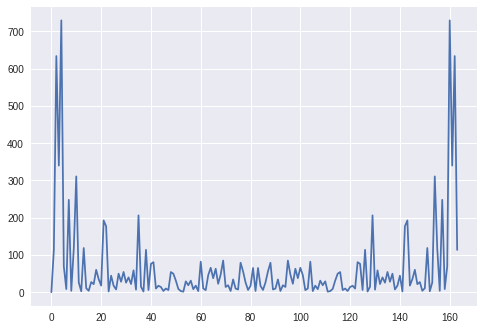

In [24]:
plt.plot(perio)

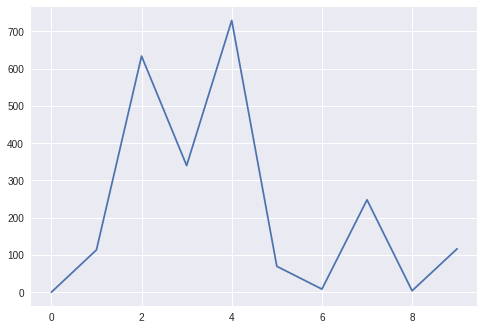

In [25]:
plt.plot(perio[:10])